<a href="https://colab.research.google.com/github/ToluPaul/Pytorch_football_prediction/blob/main/Salary_prediction_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Players Salary With Pytorch

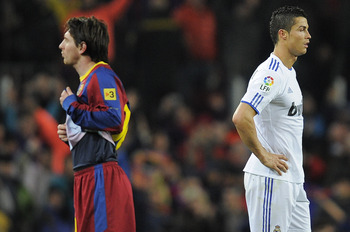

In [ ]:
from IPython.display import Image
Image('/content/ronaldo_messi.png', width=700)

<font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
- [Data Loading and Library Importation]()
- [Data Preparation](#2)
- [Model Training](#3)

# Data Loading and Library Importation

In creating a Model using pytorch:
1. Overfit the training set to see if the problem is solvable and then set a performance baseline
2. Reduce Overfitting by improving performance on the validation set
3. Slightly adjust the different hyperparameters to ensure you're acheiving the best possible performance

In [ ]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.nn import MSELoss
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot  as plt

In [ ]:
#Load the data
players_info = pd.read_csv('/content/p21_data.csv', usecols=[i for i in range(1,12)])

In [ ]:
display(players_info.head())

print("\nThe total number of inputs in the dataframe is {}".format(len(players_info)))

,value_eur,height_cm,weight_kg,potential,age,bmi,1.0,2.0,3.0,4.0,wage_eur
0,36500000.0,178,77,84,30,24.302487,1,0,0,0,120000.0
1,58500000.0,189,76,88,25,21.276000,1,0,0,0,105000.0
2,48000000.0,185,77,85,27,22.498174,1,0,0,0,81000.0
3,56000000.0,171,69,88,24,23.597004,1,0,0,0,20000.0
4,40500000.0,172,65,84,27,21.971336,1,0,0,0,27000.0



The total number of inputs in the dataframe is 14833


In [ ]:
#check for missing values
display(players_info.isna().sum())

value_eur    198
height_cm      0
weight_kg      0
potential      0
age            0
bmi            0
1.0            0
2.0            0
3.0            0
4.0            0
wage_eur     187
dtype: int64

In [ ]:
#since the number of missing values is minute compared to the dataframe size; we drop them.
players_info = players_info.dropna()
players_info.isna().sum()

value_eur    0
height_cm    0
weight_kg    0
potential    0
age          0
bmi          0
1.0          0
2.0          0
3.0          0
4.0          0
wage_eur     0
dtype: int64

In [ ]:
#now we duplicate and normalize the dataset to prepare it for training
player_info1 = players_info.copy()
display(player_info1.head())

,value_eur,height_cm,weight_kg,potential,age,bmi,1.0,2.0,3.0,4.0,wage_eur
0,36500000.0,178,77,84,30,24.302487,1,0,0,0,120000.0
1,58500000.0,189,76,88,25,21.276000,1,0,0,0,105000.0
2,48000000.0,185,77,85,27,22.498174,1,0,0,0,81000.0
3,56000000.0,171,69,88,24,23.597004,1,0,0,0,20000.0
4,40500000.0,172,65,84,27,21.971336,1,0,0,0,27000.0


In [ ]:
#normalize each column of the datafrane
player_info1['wage_eur'] = (player_info1['wage_eur'] - player_info1['wage_eur'].min()) / (player_info1['wage_eur'].max() - player_info1['wage_eur'].min())
player_info1['value_eur'] = (player_info1['value_eur'] - player_info1['value_eur'].min()) / (player_info1['value_eur'].max() - player_info1['value_eur'].min())
player_info1['height_cm'] = (player_info1['height_cm'] - player_info1['height_cm'].min()) / (player_info1['height_cm'].max() - player_info1['height_cm'].min())
player_info1['weight_kg'] = (player_info1['weight_kg'] - player_info1['weight_kg'].min()) / (player_info1['weight_kg'].max() - player_info1['weight_kg'].min())
player_info1['potential'] = (player_info1['potential'] - player_info1['potential'].min()) / (player_info1['potential'].max() - player_info1['potential'].min())
player_info1['age'] = (player_info1['age'] - player_info1['age'].min()) / (player_info1['age'].max() - player_info1['age'].min())

In [ ]:
display(player_info1.head())

,value_eur,height_cm,weight_kg,potential,age,bmi,1.0,2.0,3.0,4.0,wage_eur
0,0.623803,0.450980,0.450000,0.84375,0.518519,24.302487,1,0,0,0,0.888476
1,1.000000,0.666667,0.433333,0.96875,0.333333,21.276000,1,0,0,0,0.776952
2,0.820451,0.588235,0.450000,0.87500,0.407407,22.498174,1,0,0,0,0.598513
3,0.957250,0.313725,0.316667,0.96875,0.296296,23.597004,1,0,0,0,0.144981
4,0.692202,0.333333,0.250000,0.84375,0.407407,21.971336,1,0,0,0,0.197026


In [ ]:
#select the features and target variables of the dataset
features = player_info1[['value_eur', 'height_cm', 'weight_kg', 'potential', 'age', 'bmi', '1.0', '2.0', '3.0', '4.0']].to_numpy()
target = player_info1['wage_eur'].to_numpy().reshape((-1,1))

In [ ]:
#check the aggredated minimum value to ensure there are no negative salary values
player_info1['wage_eur'].min()

0.0

In [ ]:
#confirm the type and shape of the dataset
print(type(features))
print(target.shape)
print(features.shape)

<class 'numpy.ndarray'>
(14635, 1)
(14635, 10)


# Data Preparation

In [ ]:
#Split the dataset into train, test, and eval
#features_numpy = features.values
#target_numpy = target.values.reshape((-1,1))
X_train, X_final, y_train, y_final = train_test_split(features, target, test_size=0.3, random_state=30)
X_eval, X_test, y_eval, y_test = train_test_split(features, target, test_size=0.33, random_state=30)

In [ ]:
##Create the dataset and the dataloader
#Convert the numpy into torch datatype and load in the dataloader
train_set = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
#dataloader_overtrain = DataLoader(train_set, batch_size=5, shuffle = True)
dataloader_train = DataLoader(train_set, batch_size=5, shuffle = True)
#create dataloader for evaluation
eval_set = TensorDataset(torch.tensor(X_eval).float(), torch.tensor(y_eval).float())
dataloader_eval = DataLoader(eval_set, batch_size=5, shuffle = True)
#x, y = next(iter(dataloader))
#Create the model
model = nn.Sequential(nn.Linear(10, 14),
                      nn.Linear(14, 6),
                      nn.Linear(6, 1))
nn.init.uniform_(model[0].weight)
'''for name, param in model.named_parameters():
      if name == '0.weight':
        param.requires_grad = False'''
#Create the loss and optimizer
criterion = nn.MSELoss()
#learning rate between 0.01 and 0.0001 and momentum between 0.85 and 0.99
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
#confirm the instantiation of the features and labels datatype
features, labels = next(iter(dataloader_train))
print(features.dtype, labels.dtype)

torch.float32 torch.float32


# Model Training

In [ ]:
#Modify the training loop to overfit a single data point(batch size of 1)
features, labels = next(iter(dataloader_train))
for i in range(1):
  outputs = model(features)
  loss = criterion(outputs, labels)
  loss.backward()
  optimizer.step()
#Overfitting should give an accuracy of 1 and loss close to 0 and helps find bugs in the code
'''#Goal is not to experiment with the model architecture and use an existing one if possible as we are
trying to minimize the training loss and it should be large enough to overfit the training set and use
a default learning rate'''
print(loss)


tensor(0.0058, grad_fn=<MseLossBackward0>)


In [ ]:
#Train the model over 10 epochs to fit the data to the model
num_epochs = 100
training_loss = []
eval_loss = []
validation_loss = 0.0
#Loop through the dataset multiple times
for epoch in range(num_epochs):
  for data in (dataloader_train):
    #set the gradients to zero
    optimizer.zero_grad()
    #Get feature and target from the data loader
    feature, target = data
    #Run a forward pass
    pred = model(feature)
    #Compute loss and gradients
    loss = criterion(pred, target)
    loss.backward()
    #Update the parameters
    optimizer.step()
  training_loss.append(loss.item())
  if epoch % 10 == 9:
    print(f'Epoch: {epoch+1}, Loss: {loss.item()}')
  #print(f'Epoch: {epoch+1}, Loss: {loss.item()}')
    #print(f"EPOCH {i}", model.history.history)
  model.eval()
  with torch.no_grad():
    for data in dataloader_eval:
      outputs = model(data[0])
      loss = criterion(outputs, data[1])

      #Sum the current loss to the validation_loss variable
      validation_loss += loss

  #Calculate the mean loss value
  validation_loss_epoch = validation_loss / len(dataloader_eval)
  if epoch % 10 == 9:
    print(f"validation_loss: {validation_loss_epoch}")
  eval_loss.append(loss)
  #Set the model back to training mode
  model.train()
#show_results(model)
print("\nFinished Training")

Epoch: 10, Loss: 0.0007468641852028668
validation_loss: 0.04654817283153534
Epoch: 20, Loss: 0.0050682188011705875
validation_loss: 0.09318015724420547
Epoch: 30, Loss: 0.00043699872912839055
validation_loss: 0.13495610654354095
Epoch: 40, Loss: 0.0004487707046791911
validation_loss: 0.1722871959209442
Epoch: 50, Loss: 3.944716809201054e-05
validation_loss: 0.21123476326465607
Epoch: 60, Loss: 0.0020353093277662992
validation_loss: 0.24803517758846283
Epoch: 70, Loss: 0.005677876528352499
validation_loss: 0.2871434688568115
Epoch: 80, Loss: 0.00022596224152948707
validation_loss: 0.3209109306335449
Epoch: 90, Loss: 0.0020341193303465843
validation_loss: 0.3569849729537964
Epoch: 100, Loss: 0.04820464551448822
validation_loss: 0.39039158821105957

Finished Training


In [ ]:
"""##Evaluating your model with the evaluation dataset
eval_set = TensorDataset(torch.tensor(X_eval).float(), torch.tensor(y_eval).float())
dataloader_eval = DataLoader(eval_set, batch_size=5, shuffle = True)
#Set the moel to evaluation mode
eval_loss1 = []
model.eval()
validation_loss = 0.0

for epoch in range(num_epochs):

  with torch.no_grad():
    for data in dataloader_eval:
      outputs = model(data[0])
      loss = criterion(outputs, data[1])

      #Sum the current loss to the validation_loss variable
      validation_loss += loss

  #Calculate the mean loss value
  validation_loss_epoch = validation_loss / len(dataloader_eval)
  print(validation_loss_epoch)
  eval_loss1.append(loss)
#Set the model back to training mode
model.train()"""

tensor(0.0146)
tensor(0.0293)
tensor(0.0439)
tensor(0.0585)
tensor(0.0732)
tensor(0.0878)
tensor(0.1025)
tensor(0.1171)
tensor(0.1317)
tensor(0.1464)


Sequential(
  (0): Linear(in_features=10, out_features=14, bias=True)
  (1): Linear(in_features=14, out_features=6, bias=True)
  (2): Linear(in_features=6, out_features=1, bias=True)
)

In [ ]:
numbers = range(100)
for i in numbers:
  if i % 10 == 9:
    print(i+1)

10
20
30
40
50
60
70
80
90
100


In [ ]:
print(100% 10)


0


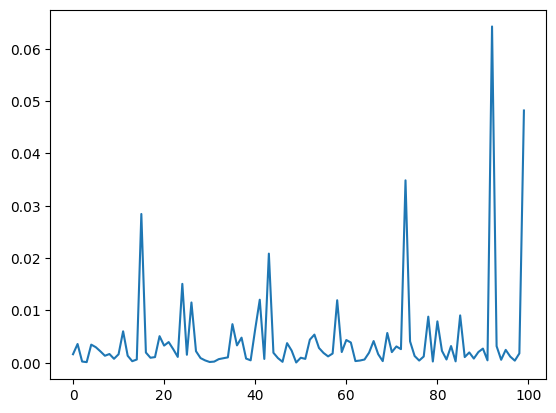

In [ ]:
plt.plot(training_loss)
plt.show()

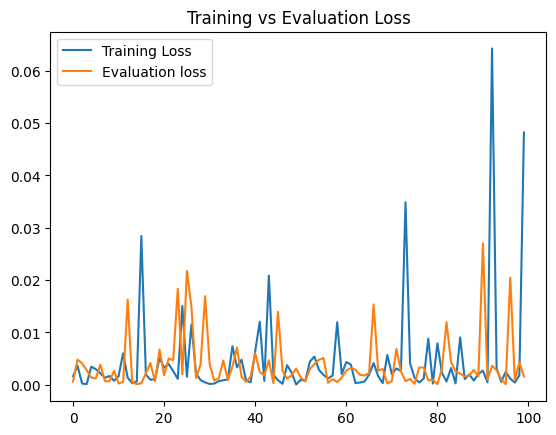

In [ ]:
plt.plot(training_loss, label="Training Loss")
plt.plot(eval_loss, label= "Evaluation loss")
plt.legend()
plt.title("Training vs Evaluation Loss")
plt.savefig("Epochloss.png")
plt.show()


In [ ]:
print(eval_loss1)

[tensor(0.0146), tensor(0.0293), tensor(0.0439), tensor(0.0585), tensor(0.0732), tensor(0.0878), tensor(0.1025), tensor(0.1171), tensor(0.1317), tensor(0.1464)]


In [ ]:
training_loss = 0.0
for i, data in enumerate(dataloader_train, 0):
  #Run the forward pass
  pred = model(torch.tensor(X_train).float())
  #Calculate the loss
  loss = criterion(pred, torch.tensor(y_train).float())
  #calculate the gradients
  #loss = criterion(pred, target)
  loss.backward()
  #Calculate and sum the loss
  training_loss += loss.item()
epoch_loss = training_loss/len(dataloader_train)
print(epoch_loss)

nan


In [ ]:
predict = model(torch.tensor(X_train).float())
output = torch.tensor(y_train).float()
mse = criterion(predict, output) #np.mean((y-y_hat) ** 2)
print(mse)

tensor(nan, grad_fn=<MseLossBackward0>)


In [ ]:
y_hat = np.array(10)
y = np.array(1)

criterion =  nn.MSELoss()

mse_pytorch = criterion(torch.from_numpy(y).float(), torch.from_numpy(y_hat).float())
print(mse_pytorch)

tensor(81.)


In [ ]:
total = 0
for parameter in model.parameters():
  total += parameter.numel()
print(total)

'''#Writing a function that calculates model capacity
def calculate_capacity(model):
  ''This is a function that calculates model capacity''
  total = 0
  for p in model.parameters():
    total += p.numel()
  return total'''

251


In [ ]:
#Check the first sample of your dataset
sample = train_set[0]
#The result of this index is a tumple which can be unpacked
input_sample, label_sample = sample
print('input sample:', input_sample)
print('label_sample:', label_sample)

input sample: tensor([3.6500e+07, 1.7800e+02, 7.7000e+01, 8.4000e+01, 3.0000e+01, 2.4302e+01,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])
label_sample: tensor([120000.])


In [ ]:
#iterate over the dataloader
'''To print all batches from the dataloader but lets use only one:
for batch_inputs, batch_labels in dataloader:
  print('batch inputs', batch_inputs)
  print('batch labels', batch_labels)'''
features, labels = next(iter(dataloader_train))
print(f"Features: {features}, \nLabels: {labels}")

Features: tensor([[1.6330e-02, 3.9216e-01, 2.6667e-01, 3.4375e-01, 2.9630e-01, 2.1551e+01,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.2408e-02, 5.6863e-01, 4.6667e-01, 5.0000e-01, 5.1852e-01, 2.3039e+01,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.7278e-02, 6.2745e-01, 5.0000e-01, 6.5625e-01, 2.2222e-01, 2.2877e+01,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.3858e-02, 3.1373e-01, 3.0000e-01, 4.3750e-01, 4.0741e-01, 2.3255e+01,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [7.7804e-03, 2.3529e-01, 3.0000e-01, 4.6875e-01, 1.8519e-01, 2.4382e+01,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]]), 
Labels: tensor([[0.0112],
        [0.1301],
        [0.0929],
        [0.0706],
        [0.0011]])


In [ ]:
'''Fine tuning hypermarameters
#Grid Search -if you have the computational capacity
 for factor in range(2,6):
  lr = 10 ** -factor
  #monmentum is between 0.85 to 0.99 all with a constant interval

#Random Search -Randomly samples parameters between intervals(often leads to better results)
factor = np.random.uniform(2,6)
lr = 10 ** -factor

example
values = []
for idx in range(10):
  # Randomly sample a learning rate factor between 2 and 4
  factor = np.random.uniform(2,4)
  lr = 10 ** -factor

  #Randomly select a momentum between 0.85 and 0.99
  momentum = np.random.uniform(0.85, 0.99)

  values.append((lr, momentum))
  Probability and statistics
  Linear Algebra
  Calculus
'''